In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
from pmlb import fetch_data

X, y = fetch_data('294_satellite_image', return_X_y=True)

In [5]:
X.shape

(6435, 36)

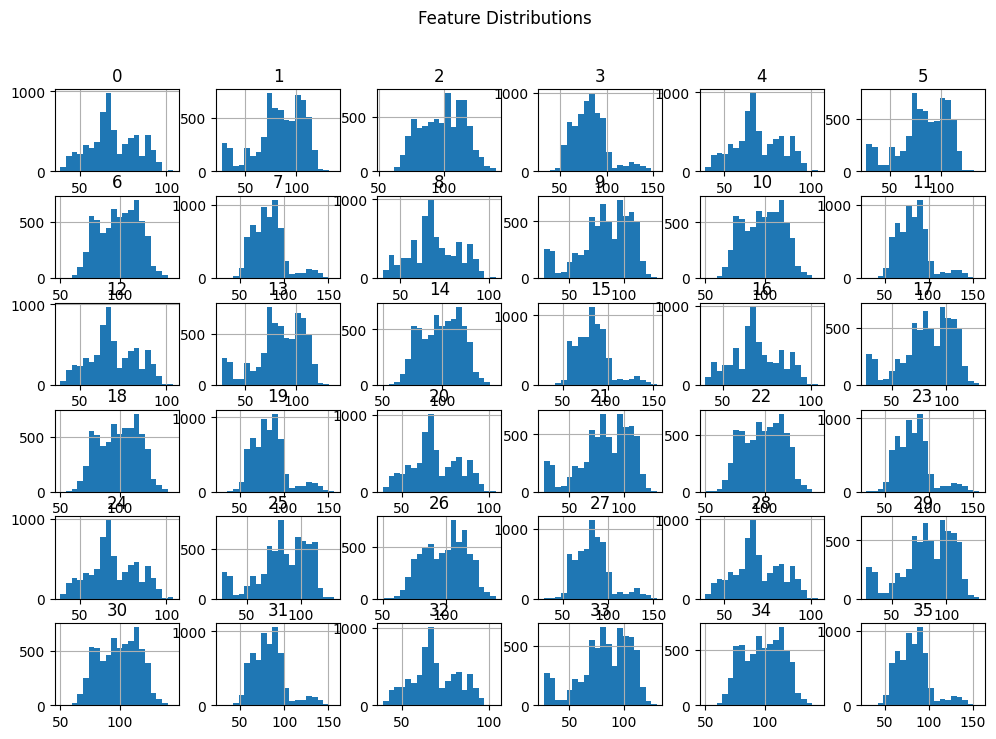

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

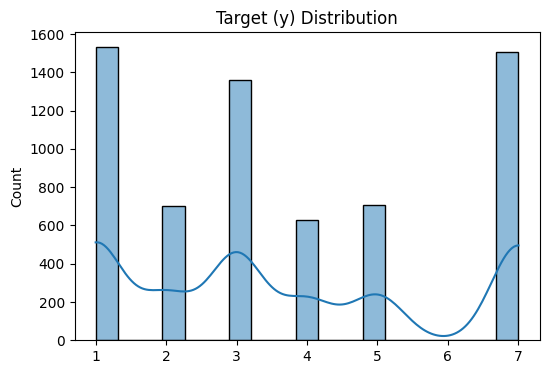

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

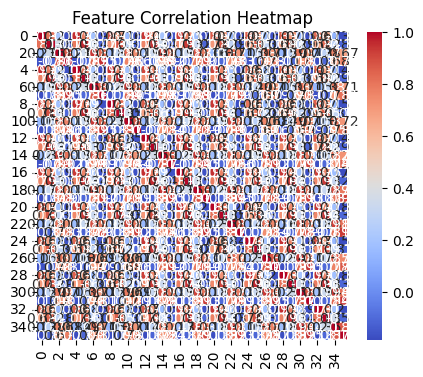

In [8]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  2.433253                 1.755938             2.390402   
1                  2.531501                 2.172315             1.739948   
2                  2.648726                 1.955421             1.188402   
3                  2.517075                 1.728044             1.757292   
4                  2.252417                 1.674062             1.426051   
mean               2.476594                 1.857156             1.700419   
std                0.146983                 0.205803             0.452303   

      DefaultBART_Rhat_RMSE  
0                  1.197364  
1                  1.460335  
2                  2.035160  
3                  1.453225  
4                  1.801732  
mean               1.589563  
std                0.328892  


In [10]:
rhat_df.to_csv("results/real7_Satellite_rhat.csv", index=False)

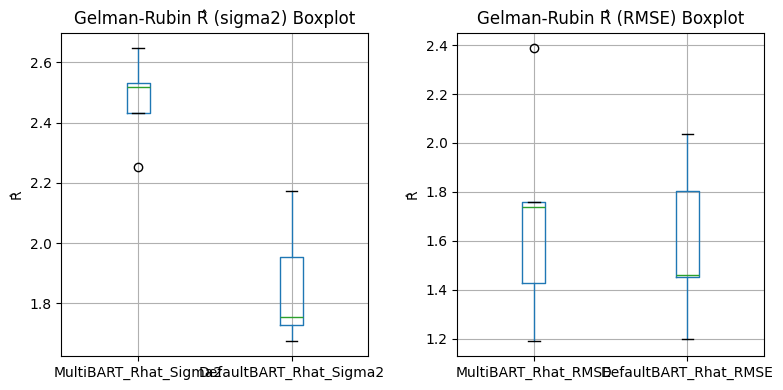

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

c:\Learning\Phd\BART\bartpy\bart_env\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


test_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.597336  0.589677  0.591074  0.489757  0.534697
1      0.673772  0.683623  0.636560  0.539908  0.580095
2      0.595408  0.633162  0.612303  0.483001  0.500649
3      0.642698  0.624540  0.681149  0.556418  0.575852
4      0.629986  0.590696  0.602730  0.483305  0.504522
5      0.604196  0.597735  0.628348  0.503560  0.567139
6      0.653312  0.594981  0.615198  0.507003  0.555896
7      0.620259  0.635501  0.587208  0.489314  0.524277
8      0.607217  0.630695  0.622374  0.519927  0.507214
9      0.615949  0.644150  0.645796  0.479440  0.539197
mean   0.624013  0.622476  0.622274  0.505163  0.538954
std    0.025826  0.029848  0.027879  0.026199  0.029869



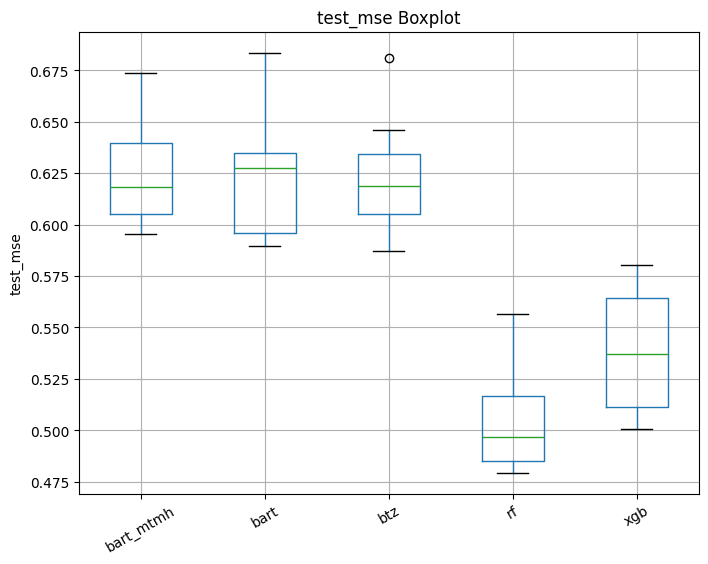

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.152880  0.299014  0.349395  0.071356  0.011611
1      0.135249  0.293954  0.321582  0.068218  0.011267
2      0.134772  0.329338  0.349185  0.071901  0.011581
3      0.111597  0.272825  0.308020  0.067736  0.011723
4      0.128483  0.304164  0.348839  0.067946  0.010618
5      0.134569  0.303691  0.346854  0.069954  0.010860
6      0.124447  0.296669  0.342673  0.070489  0.013329
7      0.131115  0.289621  0.342481  0.068721  0.012514
8      0.121407  0.298371  0.317211  0.070691  0.013440
9      0.135989  0.325691  0.348305  0.067813  0.011853
mean   0.131051  0.301334  0.337454  0.069483  0.011880
std    0.010885  0.016436  0.015622  0.001579  0.000951



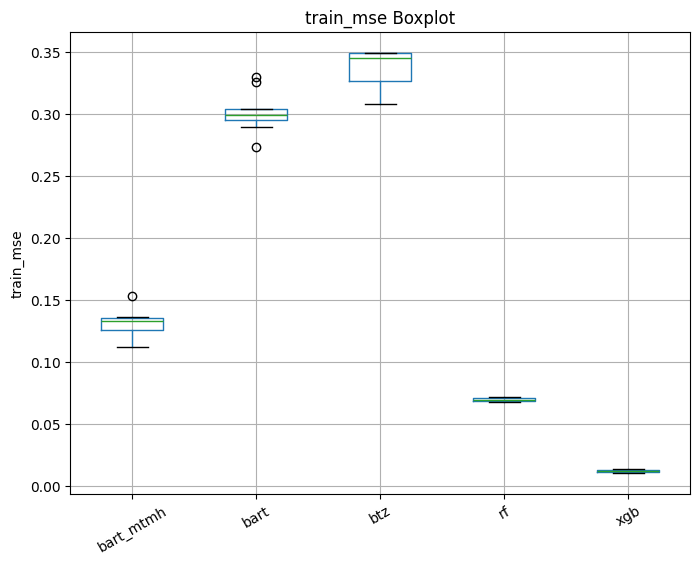

pi_length:
      bart_mtmh      bart       btz
0      1.944019  2.441576  2.861102
1      1.838296  2.404530  2.793565
2      1.842404  2.483551  2.939987
3      1.731203  2.360190  2.747785
4      1.839870  2.439443  2.880311
5      1.873824  2.431211  2.860847
6      1.786078  2.430093  2.845038
7      1.805945  2.393484  2.849716
8      1.764208  2.390522  2.802412
9      1.873861  2.517967  2.846625
mean   1.829971  2.429257  2.842739
std    0.061248  0.046235  0.052349



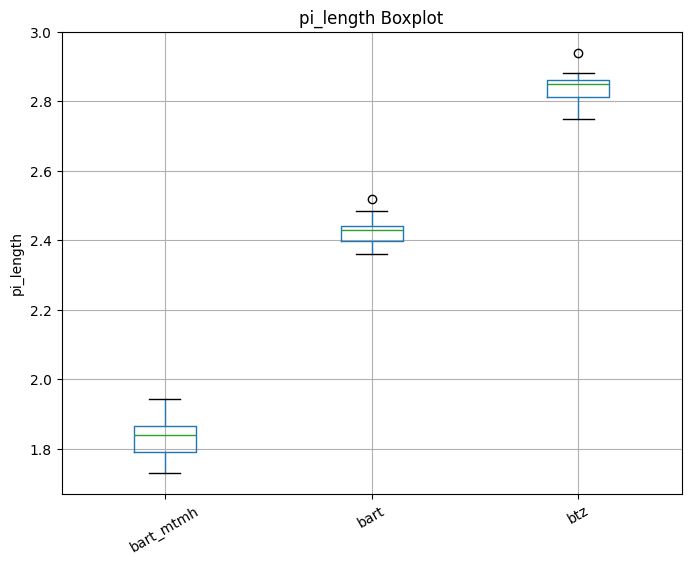

coverage:
      bart_mtmh      bart       btz
0      0.868241  0.895587  0.924798
1      0.844624  0.892480  0.908017
2      0.864512  0.888129  0.922933
3      0.847732  0.893723  0.908639
4      0.847110  0.895587  0.921069
5      0.850839  0.900559  0.924798
6      0.845245  0.899316  0.911746
7      0.846489  0.883779  0.921690
8      0.857676  0.888129  0.916718
9      0.858919  0.894966  0.914854
mean   0.853139  0.893226  0.917526
std    0.008572  0.005239  0.006459



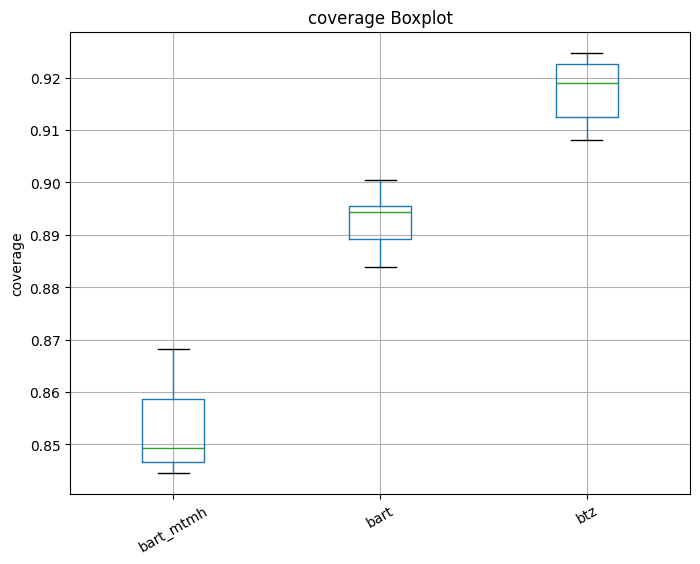

train_time:
       bart_mtmh       bart        btz        rf       xgb
0     280.211049  32.196572  33.829169  5.606807  0.604152
1     283.537024  33.168851  35.827049  4.419757  0.302188
2     285.929062  35.005320  38.758642  4.111976  0.343105
3     283.919852  33.858733  36.217799  4.355101  0.312058
4     280.973070  32.527249  34.003086  5.462224  0.312093
5     287.038162  32.498602  29.521884  5.037081  0.327708
6     288.888666  33.125108  31.750589  5.212858  0.338443
7     282.195623  32.343630  28.895505  5.321405  0.383297
8     293.634056  50.442237  25.840550  3.973404  0.262006
9     283.937639  39.951061  30.297075  4.669685  0.390678
mean  285.026420  35.511736  32.494135  4.817030  0.357573
std     4.029465   5.733089   3.939992  0.587011  0.094497



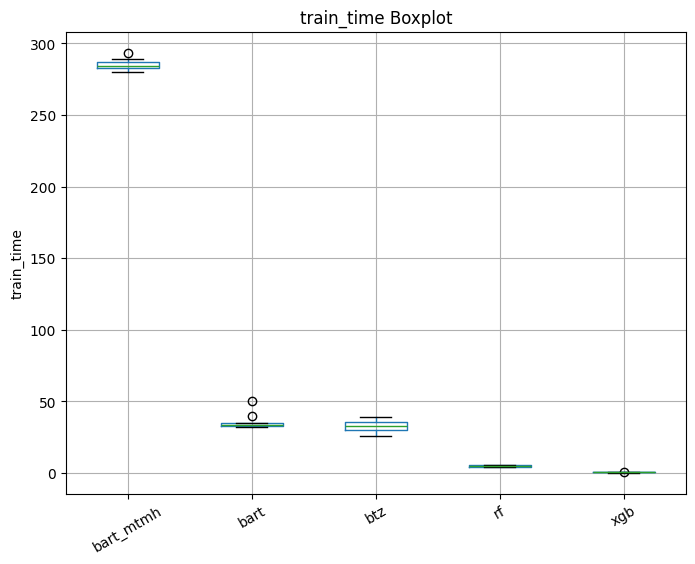

In [12]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [13]:
for k, v in mse_results.items():
    csv_name = f"results/real7_Satellite_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [14]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real7_Satellite_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real7_Satellite_tries.csv", index=False)

In [15]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage   Train_Time
0            1     1.795426   1.933920  0.627548  0.895960    57.714973
1            5     2.148839   1.744143  0.595027  0.869484   164.368983
2           10     2.476594   1.700419  0.625228  0.854195   293.116404
3           50     2.048871   1.834005  0.635107  0.814667  1462.575514
